Import external libraries.

In [18]:
library("readxl")
library("pscl")
library(data.table)
library(MLmetrics)
library(ggplot2)

Read in tile count data for BEST2 and BEST3. Change paths to ```barretts-segment-length-predictor``` directory as appropriate.

In [12]:
best2_tff3_tile_data <- read_excel("~/barretts-segment-length-predictor/data/tff3-tiles-vs-prague-length-data/BEST2_TFF3_AND_GASTRIC_TILE_COUNTS_QC_PASSING.xlsx")
best2_prague_length_data <- read_excel("~/progression-detection/data/tff3-tiles-vs-prague-length-data/BEST2_ENDOSCOPY_CRF_CLEANED_SHORTENED.xlsx")
best3_tff3_tile_data <- read_excel('~/barretts-segment-length-predictor/data/tff3-tiles-vs-prague-length-data/BEST3_TFF3_AND_GASTRIC_TILE_COUNTS_QC_PASSING.xlsx')
best3_prague_length_data <- read.csv('~/barretts-segment-length-predictor/data/tff3-tiles-vs-prague-length-data/BEST3_ENDOSCOPY_CRF_CLEANED.csv')

New names:
* `` -> ...3


Merge data appropriately and add new columns for training.

In [13]:
# Merge tile count and Prague length data and perform some cleaning tasks
best2_tff3_prague_data = merge(best2_tff3_tile_data, best2_prague_length_data, by='Case')
best3_tff3_prague_data = merge(best3_tff3_tile_data, best3_prague_length_data, by='Case')
tff3_prague_data = rbind(best2_tff3_prague_data[, c('Case', 'Gastric_count', 'TFF3_positive_count', 'PRAGUE_C', 'PRAGUE_M')],
                            best3_tff3_prague_data[, c('Case', 'Gastric_count', 'TFF3_positive_count', 'PRAGUE_C', 'PRAGUE_M')])
tff3_prague_data$PRAGUE_C <- as.numeric(tff3_prague_data$PRAGUE_C)
tff3_prague_data$PRAGUE_M <- as.numeric(tff3_prague_data$PRAGUE_M)
tff3_prague_data$TFF3_positive_count <- as.numeric(tff3_prague_data$TFF3_positive_count)
tff3_prague_data$Gastric_count <- as.numeric(tff3_prague_data$Gastric_count)

# Add C≥1 and M≥3 columns
tff3_prague_data$PRAGUE_C_gtet_1cm <- ifelse(tff3_prague_data$PRAGUE_C >= 1, 1, 0)
tff3_prague_data$PRAGUE_M_gtet_3cm <- ifelse(tff3_prague_data$PRAGUE_M >= 3, 1, 0)

# Add C≥1 OR M≥3 column
tff3_prague_data$C_gtet_1_or_M_gtet_3 <- ifelse(tff3_prague_data$PRAGUE_C >= 1 | tff3_prague_data$PRAGUE_M >= 3, 1, 0)

# Re-split data into BEST2 and BEST3 pieces
best2_tff3_prague_data <- head(tff3_prague_data, nrow(best2_tff3_prague_data))
best3_tff3_prague_data <- tail(tff3_prague_data, nrow(best3_tff3_prague_data))

# Convert to data.table
best2_tff3_prague_data <- setDT(best2_tff3_prague_data)
best3_tff3_prague_data <- setDT(best3_tff3_prague_data)
tff3_prague_data <- setDT(tff3_prague_data)
best2_tff3_endoscopy_data <- setDT(best2_tff3_endoscopy_data)

Generate Figure 2 plots.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


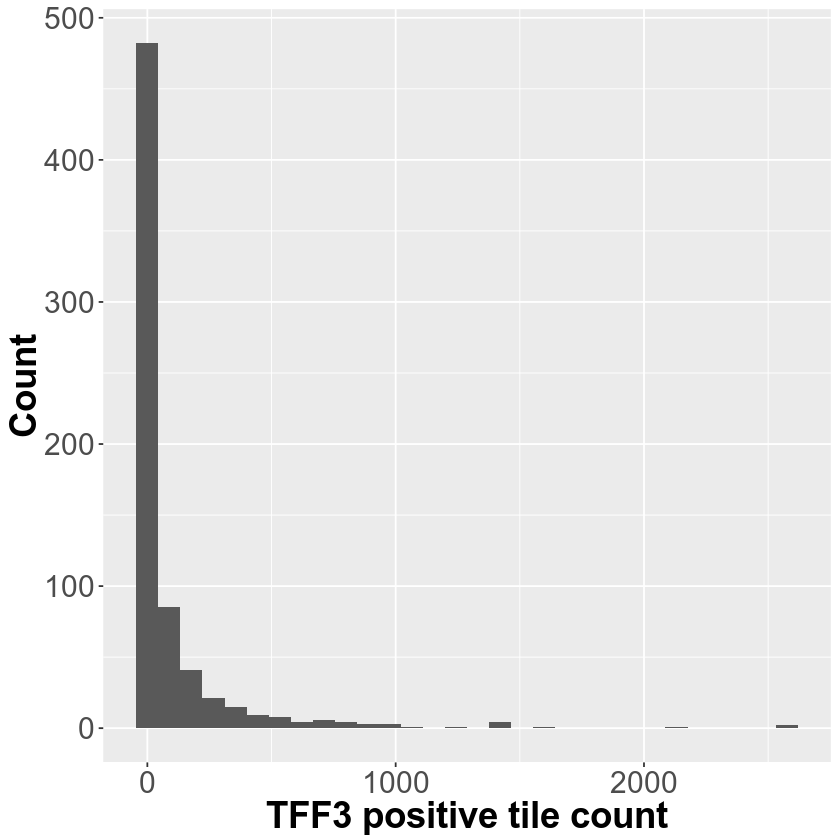

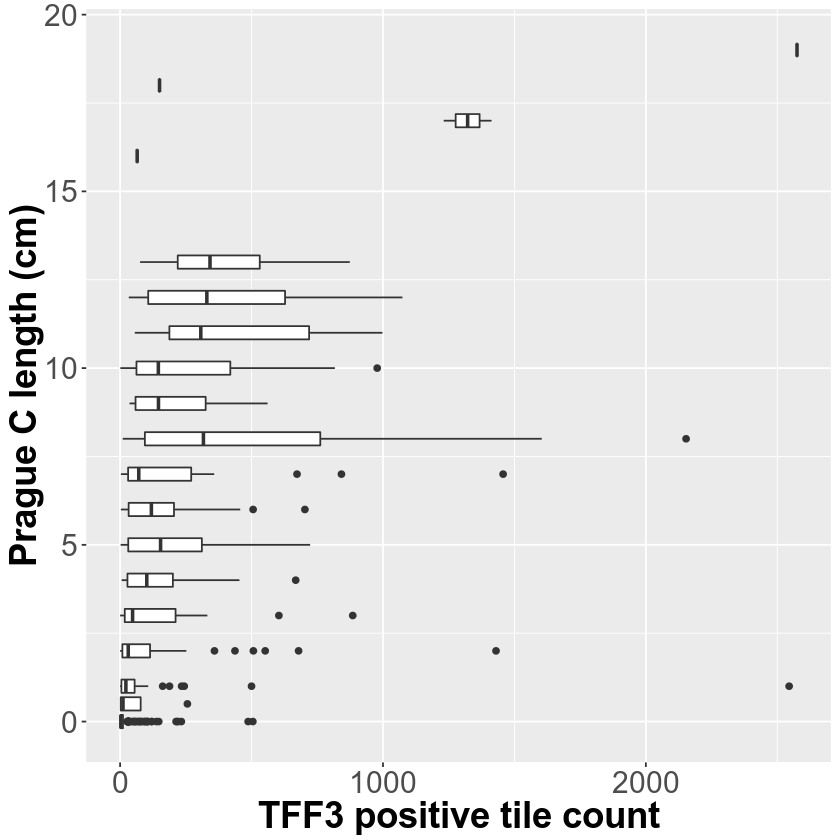

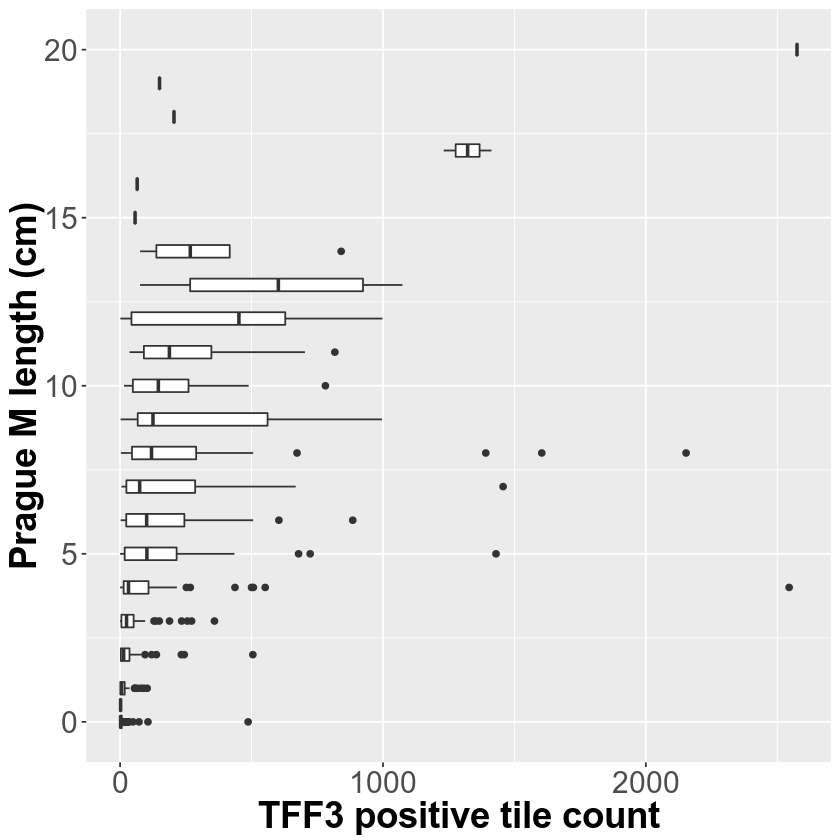

In [14]:
# Plot 2a
plot1 <- ggplot(data=tff3_prague_data, aes(x=TFF3_positive_count)) + geom_histogram() + 
    xlab('TFF3 positive tile count') + ylab('Count') + theme(axis.text=element_text(size=18), axis.title=element_text(size=22, face="bold"))
plot1
ggsave(file="~/Downloads/plot2a.svg", plot=plot1, width=10, height=10)

# Plot 2b
plot2 <- ggplot(data=tff3_prague_data, aes(x=PRAGUE_C, y=TFF3_positive_count, group=PRAGUE_C)) + 
    geom_boxplot() + xlab('Prague C length (cm)') + ylab('TFF3 positive tile count') + coord_flip() +
     theme(axis.text=element_text(size=18), axis.title=element_text(size=22, face="bold"))
plot2
ggsave(file="~/Pictures/plot2b.svg", plot=plot2, width=10, height=10)

# Plot 2c
plot3 <- ggplot(data=tff3_prague_data, aes(x=PRAGUE_M, y=TFF3_positive_count, group=PRAGUE_M)) + 
    geom_boxplot() + xlab('Prague M length (cm)') + ylab('TFF3 positive tile count') + coord_flip() +
     theme(axis.text=element_text(size=18), axis.title=element_text(size=22, face="bold"))
plot3
ggsave(file="~/Pictures/plot2c.svg", plot=plot3, width=10, height=10)

Compute Spearman's correlation coefficients.

In [15]:
# correlation metrics
print('Prague C ~ TFF3 positive tile count Spearman rho')
cor(tff3_prague_data$TFF3_positive_count, tff3_prague_data$PRAGUE_C, method = c("spearman"))
print('Prague M ~ TFF3 positive tile count Spearman rho')
cor(tff3_prague_data$TFF3_positive_count, tff3_prague_data$PRAGUE_M, method = c("spearman"))
print('Prague C ~ Gastric tile count Spearman rho')
cor(tff3_prague_data$Gastric_count, tff3_prague_data$PRAGUE_C, method = c("spearman"))
print('Prague M ~ Gastric tile count Spearman rho')
cor(tff3_prague_data$Gastric_count, tff3_prague_data$PRAGUE_M, method = c("spearman"))

[1] "Prague C ~ TFF3 positive tile count Spearman rho"


[1] 0.6743723

[1] "Prague M ~ TFF3 positive tile count Spearman rho"


[1] 0.719945

[1] "Prague C ~ Gastric tile count Spearman rho"


[1] 0.1273997

[1] "Prague M ~ Gastric tile count Spearman rho"


[1] 0.1092771

Train 5-fold cross validation logistic regression models for predicting segment length class: (C≥1 OR M≥3) vs. (C<1 AND M<3)

In [16]:
# create 5 folds for cross validation across 691 patients from BEST2 and BEST3 
# (138 patients per val fold, 553 per training fold)
set.seed(366)

# For BEST2 only analyses
#best2_tff3_prague_data_shuffled <- best2_tff3_prague_data[sample(nrow(best2_tff3_prague_data)),]

# For BEST2+BEST3 analyses
best2_tff3_prague_data_shuffled <- tff3_prague_data[sample(nrow(tff3_prague_data)),]

# split folds into training and validation components
fold_size = round(nrow(best2_tff3_prague_data_shuffled)/5)
n <- nrow(best2_tff3_prague_data_shuffled)
r  <- rep(1:ceiling(n/fold_size), each=fold_size)[1:n]
d <- split(best2_tff3_prague_data_shuffled, r)
val1 <- d[["1"]]
val2 <- d[["2"]]
val3 <- d[["3"]]
val4 <- d[["4"]]
val5 <- d[["5"]]
train1 <- rbind(val2, val3, val4, val5)
train2 <- rbind(val1, val3, val4, val5)
train3 <- rbind(val1, val2, val4, val5)
train4 <- rbind(val1, val2, val3, val5)
train5 <- rbind(val1, val2, val3, val4)

# 5-fold classification models trained on training components
logreg_c_gtet_1cm_or_m_gtet_3cm_1 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train1)
logreg_c_gtet_1cm_or_m_gtet_3cm_2 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train2)
logreg_c_gtet_1cm_or_m_gtet_3cm_3 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train3)
logreg_c_gtet_1cm_or_m_gtet_3cm_4 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train4)
logreg_c_gtet_1cm_or_m_gtet_3cm_5 <- glm(C_gtet_1_or_M_gtet_3 ~ TFF3_positive_count, family='binomial', data = train5)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Evalute model performance on validation component of each fold.

In [17]:
# define performance metric functions
RSQUARE = function(y_actual,y_predict){
  cor(y_actual,y_predict)^2
}
RMSE = function(y_actual, y_predict){
    sqrt(mean((y_predict - y_actual)^2))
}
METRIFY = function(y_actual, y_predict){
    acc = Accuracy(ifelse(y_predict >= 0.5, 1, 0), y_actual)
    prec = Precision(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=1)
    rec = Recall(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=1)
    f1 = F1_Score(y_actual, ifelse(y_predict >= 0.5, 1, 0), positive=1)
    
    list(ACC=acc, PREC=prec, REC=rec, F1=f1)
}

# get classification predictions for each fold on validation components
logreg_c_gtet_1cm_or_m_gtet_3cm_1_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_1, newdata=data.frame(TFF3_positive_count=val1$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_3cm_2_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_2, newdata=data.frame(TFF3_positive_count=val2$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_3cm_3_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_3, newdata=data.frame(TFF3_positive_count=val3$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_3cm_4_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_4, newdata=data.frame(TFF3_positive_count=val4$TFF3_positive_count), type='response')
logreg_c_gtet_1cm_or_m_gtet_3cm_5_pred <- predict(logreg_c_gtet_1cm_or_m_gtet_3cm_5, newdata=data.frame(TFF3_positive_count=val5$TFF3_positive_count), type='response')

# print performance metric results
print('LOGREG C>=1cm or M>=3cm fold 1')
METRIFY(val1$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_1_pred)
print('LOGREG C>=1cm or M>=3cm fold 2')
METRIFY(val2$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_2_pred)
print('LOGREG C>=1cm or M>=3cm fold 3')
METRIFY(val3$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_3_pred)
print('LOGREG C>=1cm or M>=3cm fold 4')
METRIFY(val4$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_4_pred)
print('LOGREG C>=1cm or M>=3cm fold 5')
METRIFY(val5$C_gtet_1_or_M_gtet_3, logreg_c_gtet_1cm_or_m_gtet_3cm_5_pred)

[1] "LOGREG C>=1cm or M>=3cm fold 1"


$ACC
[1] 0.7826087

$PREC
[1] 0.8888889

$REC
[1] 0.6666667

$F1
[1] 0.7619048

[1] "LOGREG C>=1cm or M>=3cm fold 2"


$ACC
[1] 0.7608696

$PREC
[1] 0.9268293

$REC
[1] 0.5588235

$F1
[1] 0.6972477

[1] "LOGREG C>=1cm or M>=3cm fold 3"


$ACC
[1] 0.8188406

$PREC
[1] 0.8867925

$REC
[1] 0.7121212

$F1
[1] 0.789916

[1] "LOGREG C>=1cm or M>=3cm fold 4"


$ACC
[1] 0.7536232

$PREC
[1] 0.9387755

$REC
[1] 0.5974026

$F1
[1] 0.7301587

[1] "LOGREG C>=1cm or M>=3cm fold 5"


$ACC
[1] 0.7318841

$PREC
[1] 0.92

$REC
[1] 0.5822785

$F1
[1] 0.7131783